# 使用 ECS 批量运行 Python 任务
接下来将以网格搜索（grid search），展示如何使用 AWS SDK 批量运行 Python 任务。

### 定义参数

与之前的步骤一样，我们首先定义一些实验需要用到的环境变量：

In [1]:
import boto3

aws_account_id = boto3.client('sts').get_caller_identity().get('Account')
repository_name = 'ecs-gridsearch'
aws_region = 'us-east-1'
my_name = 'peng'
bucket = 'algo-trading-workshop-{}'.format(my_name)

### 获取数据

与回测示例中展示的一样，我们选择一支股票，然后通过 Athena 获取行情数据：

In [2]:
# !pip install awswrangler

import awswrangler as wr

s3_output = wr.athena.create_athena_bucket()

def execute_query(database, sql):
    
    query_execution_id = wr.athena.start_query_execution(database=database, sql=sql)
    response = wr.athena.get_query_execution(query_execution_id=query_execution_id)
    wr.athena.wait_query(query_execution_id=query_execution_id)
    OutputLocation = response['ResultConfiguration']['OutputLocation']
    
    return OutputLocation

In [3]:
database = 'stock-data'
table = 'stock_day'
fields = '*'
ticker = '600519'
orderby = 'tradedate'
sort = 'ASC'

sql = f'''
SELECT {fields}
FROM "{database}"."{table}"
WHERE ticker='{ticker}'
AND tradedate>='2019-01-01'
ORDER BY {orderby}
{sort}
'''

output_location = execute_query(database, sql)
print(output_location)

s3://aws-athena-query-results-364198545638-us-east-1/8428bc9b-814b-4b0d-95bf-e25ae69cb3ab.csv


In [4]:
df = wr.s3.read_csv(path=[output_location])

df['ticker'] = df['ticker'].apply(lambda x: str(x))
df['ticker'] = df['ticker'].apply(lambda x: '0'*(6-len(x)) + x)
df['openprice'] = df['openprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['closeprice'] = df['closeprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['highestprice'] = df['highestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['lowestprice'] = df['lowestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df = df[df['isopen'] == True]
df.drop('isopen', 1, inplace=True)
df.drop('accumadjfactor', 1, inplace=True)
df.set_index('tradedate', inplace=True)
df.sort_index(0, inplace=True)

df.rename(columns={'openprice': 'open'}, inplace=True)
df.rename(columns={'closeprice': 'close'}, inplace=True)
df.rename(columns={'highestprice': 'high'}, inplace=True)
df.rename(columns={'lowestprice': 'low'}, inplace=True)
df.rename(columns={'turnovervol': 'volume'}, inplace=True)
df['openinterest'] = 0 # A股回测中一般并不考虑利率，通常可以直接设为 0
df.head()

,ticker,secid,open,high,low,close,volume,turnovervalue,openinterest
tradedate,,,,,,,,,
2019-01-02,600519,600519.SH,588.598322,590.547514,574.153066,577.983905,6228649.0,3.754388e+09,0
2019-01-03,600519,600519.SH,578.939203,580.569963,565.265905,569.318682,3097735.0,1.838179e+09,0
2019-01-04,600519,600519.SH,566.694027,586.369294,561.618406,580.898045,3768347.0,2.258501e+09,0
2019-01-07,600519,600519.SH,586.687727,590.547514,581.110333,584.265710,3475013.0,2.105981e+09,0
2019-01-08,600519,600519.SH,584.275359,590.547514,579.238336,583.590247,2883813.0,1.750413e+09,0


将结果保存在这个实验专用的路径下，这个路径还将用于保存批量任务的输入和输出结果：

In [5]:
wr.s3.to_csv(df=df, path='s3://{}/{}/data.csv'.format(bucket, repository_name))

{'paths': ['s3://algo-trading-workshop-peng/ecs-gridsearch/data.csv'],
 'partitions_values': {}}

### 定义回测任务

接下来我们将定义实验所用的超参，这个示例中将采用 range(5,10) 日快线和 range(10,30) 日慢线为例，一共构建 5x20=100 个并行任务。这里我们可以用一个 json 文件来存储每个并行任务的超参：

In [6]:
s3 = boto3.client('s3', region_name=aws_region)

In [7]:
import json

counter = 0
for i in range(5, 10):
    for j in range(10, 30):
        counter += 1
        params = {
            'fastmaperiod': i,
            'slowmaperiod': j
        }
        s3.put_object(Body=json.dumps(params), Bucket=bucket, Key='{}/trial_{}/input/params.json'.format(repository_name, str(counter)))

num_trials = counter

接下来我们先准备一个回测脚本：

In [8]:
!mkdir {repository_name}

In [9]:
%%writefile {repository_name}/backtest.py
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from datetime import datetime
import json
import numpy as np
import pandas as pd
import os.path
import sys

import backtrader as bt

class MyStrategy(bt.Strategy):
    ## 全局参数
    params=(('fastmaperiod', 10),
            ('slowmaperiod', 30),
            ('printlog', False),)

    ## 策略初始化
    def __init__(self):

        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # 添加移动均线指标。Backtrader 集成了 talib，可以自动算出一些常见的技术指标
        self.fastma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.fastmaperiod)
        self.slowma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.slowmaperiod)
        
    ## 策略核心逻辑
    def next(self):
        # 记录收盘价
#         self.log('收盘价：%.2f' % self.datas[0].close[0])
        if self.order: # 检查是否有指令等待执行
            return
        # 检查是否持仓   
        if not self.position: # 如果没有持仓
            # 快线上穿慢线，执行买入
            if self.fastma[0] > self.slowma[0]:
                self.log('买入委托：%.2f' % self.datas[0].close[0])
                #执行买入
                self.size = int(self.broker.cash / self.datas[0].close[0])
                self.order = self.buy(size=self.size)
        else: # 
            # 快线下穿慢线，执行卖出
            if self.fastma[0] < self.slowma[0]:
                self.log('卖出委托：%.2f' % self.datas[0].close[0])
                #执行卖出
                self.order = self.sell(size=self.size)

    ## 4、日志记录
    # 交易记录日志（可选，默认不输出结果）
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')

    # 记录交易执行情况（可选，默认不输出结果）
    def notify_order(self, order):
        # 如果 order 为 submitted/accepted，返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果 order 为 buy/sell executed，报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入：\n价格：%.2f,\
                交易金额：-%.2f,\
                手续费：%.2f' % (order.executed.price, order.executed.value, order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：%.2f,\
                交易金额：%.2f,\
                手续费：%.2f' % (order.executed.price, order.executed.price*self.size, order.executed.comm))
            self.bar_executed = len(self) 

        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None

    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    # 回测结束后输出结果（可省略，默认输出结果）
    def stop(self):
        self.log('(MA均线： %2d日  %2d日) 期末总资金 %.2f' %
                 (self.params.fastmaperiod, self.params.slowmaperiod, self.broker.getvalue()), doprint=True)


if __name__ == '__main__':
    # 创建 Cerebro 对象
    cerebro = bt.Cerebro()

    df = pd.read_csv('/home/environment/data.csv')
    df.set_index('tradedate', inplace=True)
    
    # 创建 Data Feed
    df.index = pd.to_datetime(df.index)
    start = df.index[0]
    end = df.index[-1]
    print(start, '-', end)
    data = bt.feeds.PandasData(dataname=df, fromdate=start, todate=end)
    # 将 Data Feed 添加至 Cerebro
    cerebro.adddata(data)

    # 添加策略 Cerebro
    with open('/home/environment/input/params.json', 'r') as fin:
        params = json.load(fin)
    cerebro.addstrategy(MyStrategy, fastmaperiod=params['fastmaperiod'], slowmaperiod=params['slowmaperiod'], printlog=True)
    
    # 设置初始资金
    cerebro.broker.setcash(100000.0)
    # 设置手续费为万二
    cerebro.broker.setcommission(commission=0.0002) 

    # 在开始时 print 初始账户价值
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # 运行回测流程
    cerebro.run()

    # 在结束时 print 最终账户价值
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    # 输出最终账户价值和收益率
    output = {
        "value": cerebro.broker.getvalue(), 
        "return": float(cerebro.broker.getvalue())/1e5 - 1
    }
    with open('/home/environment/output/output.json', 'w') as fout:
        json.dump(output, fout)

Writing ecs-gridsearch/backtest.py


### 创建镜像仓库和容器镜像

接下来构建一个 python3 容器镜像和镜像仓库：

In [10]:
ecs = boto3.client('ecs', region_name=aws_region)
ecr = boto3.client('ecr', region_name=aws_region)

In [11]:
ecr.create_repository(repositoryName=repository_name)

{'repository': {'repositoryArn': 'arn:aws:ecr:us-east-1:364198545638:repository/ecs-gridsearch',
  'registryId': '364198545638',
  'repositoryName': 'ecs-gridsearch',
  'repositoryUri': '364198545638.dkr.ecr.us-east-1.amazonaws.com/ecs-gridsearch',
  'createdAt': datetime.datetime(2021, 12, 9, 7, 51, 5, tzinfo=tzlocal()),
  'imageTagMutability': 'MUTABLE',
  'imageScanningConfiguration': {'scanOnPush': False},
  'encryptionConfiguration': {'encryptionType': 'AES256'}},
 'ResponseMetadata': {'RequestId': 'a233cfd7-2d67-42a2-96bb-eadfd7f172d2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a233cfd7-2d67-42a2-96bb-eadfd7f172d2',
   'date': 'Thu, 09 Dec 2021 07:51:05 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '396'},
  'RetryAttempts': 0}}

In [12]:
%%writefile {repository_name}/Dockerfile
FROM python:3.6

RUN pip --no-cache-dir install \
    backtrader\
    boto3 \
    pandas

RUN curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip" && unzip awscliv2.zip && ./aws/install && rm awscliv2.zip && rm -rf aws/

ENV ENVIRONMENT="/home/environment"
RUN mkdir -p $ENVIRONMENT/input
RUN mkdir -p $ENVIRONMENT/output
COPY backtest.py $ENVIRONMENT/
CMD aws s3 cp s3://$BUCKET/$PREFIX/trial_$TRIAL/input/ $ENVIRONMENT/input/ --recursive && \
    aws s3 cp s3://$BUCKET/$PREFIX/data.csv $ENVIRONMENT/data.csv && \
    python $ENVIRONMENT/backtest.py && \
    aws s3 cp $ENVIRONMENT/output/ s3://$BUCKET/$PREFIX/trial_$TRIAL/output/ --recursive

Writing ecs-gridsearch/Dockerfile


In [ ]:
!docker build {repository_name} -t {repository_name}

In [14]:
!docker tag {repository_name} {aws_account_id}.dkr.ecr.{aws_region}.amazonaws.com/{repository_name}

In [15]:
!docker images

REPOSITORY                                                             TAG       IMAGE ID       CREATED          SIZE
364198545638.dkr.ecr.us-east-1.amazonaws.com/ecs-gridsearch            latest    198b80057241   54 seconds ago   1.23GB
ecs-gridsearch                                                         latest    198b80057241   54 seconds ago   1.23GB
364198545638.dkr.ecr.us-east-1.amazonaws.com/ecs-demo-php-simple-app   latest    b7100a00e52a   22 minutes ago   529MB
ecs-demo-php-simple-app                                                latest    b7100a00e52a   22 minutes ago   529MB
python                                                                 3.6       ea3a963a14d5   6 days ago       902MB
public.ecr.aws/amazonlinux/amazonlinux                                 2         d7b15f736b7e   7 days ago       164MB


同样的，将镜像 push 到 ECR：

In [16]:
!aws ecr get-login-password | docker login --username AWS --password-stdin {aws_account_id}.dkr.ecr.{aws_region}.amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [17]:
!docker push {aws_account_id}.dkr.ecr.{aws_region}.amazonaws.com/{repository_name}

Using default tag: latest
The push refers to repository [364198545638.dkr.ecr.us-east-1.amazonaws.com/ecs-gridsearch]

dfaacd8c: Preparing 
a74eb2c3: Preparing 
0d903ce1: Preparing 
8498e588: Preparing 
c5f9f96f: Preparing 
46b4d89f: Preparing 
703d63f9: Preparing 
4bfcf7fc: Preparing 
6d85febd: Preparing 
1e7436b1: Preparing 
1d7cb46b: Preparing 
0de04cb3: Preparing 
336bbfff: Preparing 
1e7436b1: Pushed   537.7MB/528.4MBlatest: digest: sha256:0e199ef6d04c70b0246f8e8fec8c8fc0691c50643883dc1b332acfe859dea6d5 size: 3265


### 创建 ECR 任务定义

在这个 task definition 中我们定义了将日志传输到一个名为 ecs-gridsearch 日志组的配置。在运行任务之前，需要在 CloudWatch 控制台中创建这样的一个日志组：

In [18]:
logs = boto3.client('logs')
logs.create_log_group(logGroupName=repository_name)

{'ResponseMetadata': {'RequestId': '49de0d68-be76-423c-830f-9db25083b99a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '49de0d68-be76-423c-830f-9db25083b99a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 09 Dec 2021 07:55:48 GMT'},
  'RetryAttempts': 0}}

In [19]:
ecs.register_task_definition(
    family=repository_name,
    networkMode="awsvpc",
    executionRoleArn="arn:aws:iam::{}:role/ecsTaskExecutionRole".format(aws_account_id),
    containerDefinitions=[
        {
            "name": repository_name,
            "image": "{}.dkr.ecr.{}.amazonaws.com/{}".format(aws_account_id, aws_region, repository_name),
            "essential": True,
            "logConfiguration": {
                "logDriver": "awslogs",
                "options": {
                    "awslogs-group": repository_name,
                    "awslogs-region": aws_region,
                    "awslogs-stream-prefix": repository_name
                }
            },
        },
    ],
    requiresCompatibilities=["FARGATE"],
    memory="2048",
    cpu="1024"
)

{'taskDefinition': {'taskDefinitionArn': 'arn:aws:ecs:us-east-1:364198545638:task-definition/ecs-gridsearch:1',
  'containerDefinitions': [{'name': 'ecs-gridsearch',
    'image': '364198545638.dkr.ecr.us-east-1.amazonaws.com/ecs-gridsearch',
    'cpu': 0,
    'portMappings': [],
    'essential': True,
    'environment': [],
    'mountPoints': [],
    'volumesFrom': [],
    'logConfiguration': {'logDriver': 'awslogs',
     'options': {'awslogs-group': 'ecs-gridsearch',
      'awslogs-region': 'us-east-1',
      'awslogs-stream-prefix': 'ecs-gridsearch'}}}],
  'family': 'ecs-gridsearch',
  'executionRoleArn': 'arn:aws:iam::364198545638:role/ecsTaskExecutionRole',
  'networkMode': 'awsvpc',
  'revision': 1,
  'volumes': [],
  'status': 'ACTIVE',
  'requiresAttributes': [{'name': 'com.amazonaws.ecs.capability.logging-driver.awslogs'},
   {'name': 'ecs.capability.execution-role-awslogs'},
   {'name': 'com.amazonaws.ecs.capability.ecr-auth'},
   {'name': 'com.amazonaws.ecs.capability.docker-

### 运行任务

这里建议用私有子网和 no ingress 安全组来运行 ECS 任务：

In [20]:
task_definition = "arn:aws:ecs:us-east-1:364198545638:task-definition/ecs-gridsearch:1"
subnet1 = "subnet-0a269e80a1bc0bfec"
subnet2 = "subnet-02a4f4d29f7768343"
subnet3 = "subnet-0cf156424a9f4df0f"
sg = "sg-054a37871c9ace9f1"

task_role = "arn:aws:iam::{}:role/ecsTaskRole".format(aws_account_id)

In [21]:
print('开始参数搜索，共', num_trials, '组参数:')
task_list = []
for i in range(num_trials):
    r = ecs.run_task(
        cluster='algo-trading-workshop',
        enableExecuteCommand=False,
        group='family:{}'.format(repository_name),
        launchType='FARGATE',
        networkConfiguration={
            'awsvpcConfiguration': {
                'subnets': [subnet1, subnet2, subnet3],
                'securityGroups': [sg]
            }
        },
        overrides={
            'containerOverrides': [
                {
                    'name': repository_name,
                    'environment': [
                        {
                            'name': 'BUCKET',
                            'value': bucket
                        },
                        {
                            'name': 'PREFIX',
                            'value': repository_name
                        },
                        {
                            'name': 'TRIAL',
                            'value': str(i+1)
                        }
                    ]
                },
            ],
            'taskRoleArn': task_role
        },
        taskDefinition=task_definition
    )
    task_list.append(r['tasks'][0]['taskArn'])

开始参数搜索，共 100 组参数:


我们可以用一些自定义的代码来跟踪任务的进展，或者通过控制台查看任务进度：

In [22]:
import time

r = ecs.describe_tasks(cluster='algo-trading-workshop', tasks=task_list)
stopped_count = 0
while stopped_count < num_trials:
    pending_count = 0
    provision_count = 0
    running_count = 0
    deprovision_count = 0
    stopped_count = 0
    for i in range(len(r['tasks'])):
        if r['tasks'][i]['lastStatus'] == 'PROVISIONING':
            provision_count += 1
        elif r['tasks'][i]['lastStatus'] == 'PENDING':
            pending_count += 1
        elif r['tasks'][i]['lastStatus'] == 'RUNNING':
            running_count += 1
        elif r['tasks'][i]['lastStatus'] == 'DEPROVISIONING':
            deprovision_count += 1
        elif r['tasks'][i]['lastStatus'] == 'STOPPED':
            stopped_count += 1
    print('PROVISIONING JOBS:', provision_count, 'PENDING JOBS:', pending_count, 'RUNNING JOBS:', running_count, 'DEPROVISIONING JOBS:', deprovision_count, 'STOPPED JOBS:', stopped_count)
    time.sleep(5)
    r = ecs.describe_tasks(cluster='algo-trading-workshop', tasks=task_list)

PROVISIONING JOBS: 4 PENDING JOBS: 37 RUNNING JOBS: 20 DEPROVISIONING JOBS: 16 STOPPED JOBS: 23
PROVISIONING JOBS: 4 PENDING JOBS: 29 RUNNING JOBS: 20 DEPROVISIONING JOBS: 13 STOPPED JOBS: 34
PROVISIONING JOBS: 2 PENDING JOBS: 25 RUNNING JOBS: 17 DEPROVISIONING JOBS: 19 STOPPED JOBS: 37
PROVISIONING JOBS: 2 PENDING JOBS: 20 RUNNING JOBS: 13 DEPROVISIONING JOBS: 21 STOPPED JOBS: 44
PROVISIONING JOBS: 2 PENDING JOBS: 11 RUNNING JOBS: 15 DEPROVISIONING JOBS: 19 STOPPED JOBS: 53
PROVISIONING JOBS: 1 PENDING JOBS: 10 RUNNING JOBS: 13 DEPROVISIONING JOBS: 13 STOPPED JOBS: 63
PROVISIONING JOBS: 0 PENDING JOBS: 8 RUNNING JOBS: 7 DEPROVISIONING JOBS: 17 STOPPED JOBS: 68
PROVISIONING JOBS: 0 PENDING JOBS: 7 RUNNING JOBS: 4 DEPROVISIONING JOBS: 15 STOPPED JOBS: 74
PROVISIONING JOBS: 0 PENDING JOBS: 5 RUNNING JOBS: 4 DEPROVISIONING JOBS: 10 STOPPED JOBS: 81
PROVISIONING JOBS: 0 PENDING JOBS: 4 RUNNING JOBS: 4 DEPROVISIONING JOBS: 4 STOPPED JOBS: 88
PROVISIONING JOBS: 0 PENDING JOBS: 1 RUNNING JOBS

task 的日志结果可以在 CloudWatch 中查看。接下来，我们可以获取回测的结果到一个 DataFrame 中，并通过 heat map 进行可视化：

In [23]:
import pandas as pd

result = []
for i in range(num_trials):
    key = '{}/trial_{}/input/params.json'.format(repository_name, str(i+1))
    params = json.loads(s3.get_object(Bucket=bucket, Key=key)['Body'].read())
    key = '{}/trial_{}/output/output.json'.format(repository_name, str(i+1))
    output = json.loads(s3.get_object(Bucket=bucket, Key=key)['Body'].read())
    result.append(list(params.values()) + list(output.values()))

result = pd.DataFrame(result, columns=['fastmaperiod', 'slowmaperiod', 'accountvalue', 'return'])
result = result.sort_values(['return'], ascending=False)
result.head()

,fastmaperiod,slowmaperiod,accountvalue,return
50,7,20,242489.445683,1.424894
67,8,17,240377.537246,1.403775
84,9,14,234396.734810,1.343967
48,7,18,232683.832013,1.326838
68,8,18,230094.815229,1.300948


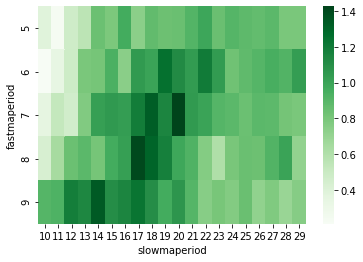

In [24]:
import seaborn

seaborn.heatmap(result.pivot('fastmaperiod', 'slowmaperiod', 'return'), cmap="Greens")